In [1]:
gpt_specs = {
            "num_layers": 2,
        "num_heads": 8,
        "head_size": 32,
        "vocab_size": 50259,
        "hidden_size": 256,
        "max_position_embeddings": 512
}

In [69]:
import json
import w3d2_tests
import transformers
import torch
from einops import rearrange, reduce, repeat

model = w3d2_tests.get_minigpt("model.pt")
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer._add_tokens(["[BEGIN]", "[END]"])
tokenizer.pad_token = "[END]"
tokenizer.eos_token = "[END]"
# 50258 is the pad_token_id
# 50257 is the BEGIN token id

with open("test_tokens_owt_subset.json") as f:
    test_tokens = torch.LongTensor(json.load(f))[:,:512]

sentences = ["So far, we've developed a theoretical model for understanding two-layer attention-only models.",
            "We have an overall equation describing the logits (the OV circuit), and then an equation describing how each attention head's attention pattern is computed (the QK circuit).",
             "But how do we understand them in practice?",
             "In this section, we'll reverse engineer a single two-layer model."]

In [70]:
model.state_dict().keys()

odict_keys(['token_embedding.weight', 'pos_embedding.weight', 'blocks.0.project_qkv.weight', 'blocks.0.project_output.weight', 'blocks.1.project_qkv.weight', 'blocks.1.project_output.weight'])

# 1

1,4 and 1,6 are induction heads

repetitive sentences repsond best. Key/sum and query/sum make it most obvious

In [71]:
def get_pairs(sentence):
    tokens = torch.tensor(tokenizer('[BEGIN] ' + sentence)['input_ids'])
    positions = torch.arange(len(tokens))
    # prod_tokens = rearrange(torch.cartesian_prod(tokens, tokens),
    #                         "(seq_len1 seq_len2) a -> seq_len1 seq_len2 a",
    #                         seq_len1 = len(tokens), 
    #                         seq_len2 = len(tokens))
    # prod_positions = rearrange(torch.cartesian_prod(positions, positions),
    #                         "(seq_len1 seq_len2) a -> seq_len1 seq_len2 a",
    #                         seq_len1 = len(tokens), 
    #                         seq_len2 = len(tokens))
    return tokens, positions

In [38]:
def embed_pairs(prod_tokens, prod_positions):
    return model.token_embedding(prod_tokens), model.pos_embedding(prod_positions)

In [39]:
pairs = get_pairs(sentence)

In [40]:
embed_pairs(*pairs)[0].shape, embed_pairs(*pairs)[1].shape

(torch.Size([23, 256]), torch.Size([23, 256]))

In [156]:
def attention_terms(token_embeddings, position_embeddings):
    # out: [seqlen, seqlen, 4]
    seq_len = token_embeddings.shape[0]
    block = model.blocks[0]
    
    token_q, token_k, _ = torch.split(block.project_qkv(token_embeddings), block.hidden_size, dim=-1)
    pos_q, pos_k, _ = torch.split(block.project_qkv(position_embeddings), block.hidden_size, dim=-1)
    
    Qs = torch.stack([token_q, pos_q], dim=0) # [2, seqlen, channel_size * heads]
    Ks = torch.stack([token_k, pos_k], dim=0) # [2, seqlen, channel_size * heads]

    Qs = rearrange(Qs, 'b n (h l) -> b h n l', l=block.head_size)
    Ks = rearrange(Ks, 'b n (h l) -> b h n l', l=block.head_size)

    neg_inf = torch.tensor(-1e4)
    q_ind = torch.arange(seq_len).unsqueeze(1)
    k_ind = torch.arange(seq_len).unsqueeze(0)
    mask = (q_ind < k_ind)
    
    # ahls = [from token/pos, head, from seqlen, channel_size]
    # bhms = [to token/pos, head, to seqlen, channel_size]
    # abhlm = [from token/pos, to token/pos, head, from seqlen, to seqlen]
    attn_scores = torch.einsum('ahql, bhkl -> abhqk', Qs, Ks) / torch.sqrt(torch.tensor(block.head_size))
    
    attn_scores = torch.where(mask, torch.tensor(0.0), attn_scores)
    print(attn_scores.shape)
    return attn_scores

print(attention_terms(*embed_pairs(*pairs))[...,0,5])

torch.Size([2, 2, 8, 23, 23])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]], grad_fn=<SelectBackward0>)


In [83]:
def attention_terms_for_sentence(sentence):
    pairs = get_pairs(sentence)
    embeddings = embed_pairs(*pairs)
    return attention_terms(*embeddings)

attention_terms_for_sentence('[BEGIN]')

torch.Size([2, 2, 8, 2, 2])


tensor([[[[[ 2.8871e-02,  0.0000e+00],
           [ 2.8871e-02,  2.8871e-02]],

          [[ 4.7161e-01,  0.0000e+00],
           [ 4.7161e-01,  4.7161e-01]],

          [[-6.2885e-02,  0.0000e+00],
           [-6.2885e-02, -6.2885e-02]],

          [[ 1.9016e-01,  0.0000e+00],
           [ 1.9016e-01,  1.9016e-01]],

          [[ 3.4188e-02,  0.0000e+00],
           [ 3.4188e-02,  3.4188e-02]],

          [[ 2.2956e-03,  0.0000e+00],
           [ 2.2956e-03,  2.2956e-03]],

          [[-2.1738e-02,  0.0000e+00],
           [-2.1738e-02, -2.1738e-02]],

          [[ 1.4150e-01,  0.0000e+00],
           [ 1.4150e-01,  1.4150e-01]]],


         [[[-5.4702e-01,  0.0000e+00],
           [-5.4702e-01, -3.1719e-01]],

          [[-6.6569e-01,  0.0000e+00],
           [-6.6569e-01, -1.1154e+00]],

          [[ 2.1303e-01,  0.0000e+00],
           [ 2.1303e-01,  2.3693e-01]],

          [[-7.9324e-01,  0.0000e+00],
           [-7.9324e-01, -1.9892e-01]],

          [[-8.2894e-01,  0.0000e+00],

In [84]:
all_attentions = [attention_terms_for_sentence(sentence) for sentence in sentences]

torch.Size([2, 2, 8, 20, 20])
torch.Size([2, 2, 8, 36, 36])
torch.Size([2, 2, 8, 10, 10])
torch.Size([2, 2, 8, 16, 16])


In [85]:
torch.var(all_attentions[0], dim=(-3, -2, -1)) # var across heads, q seqlen, k seqlen

tensor([[0.7388, 1.2714],
        [0.0859, 3.4455]], grad_fn=<VarBackward0>)

tok -> tok: 0.7388

tok -> pos: 1.2714

pos -> tok: 0.0859
pos -> pos: 3.4455

In [105]:
v = torch.var(all_attentions[0], dim=(-2, -1)) # var across q seqlen, k seqlen
v

tensor([[[0.4230, 3.1142, 0.1544, 0.6491, 0.5342, 0.1480, 0.1028, 0.7341],
         [0.6292, 3.3412, 0.0606, 2.4552, 0.2904, 0.2766, 0.3713, 2.5883]],

        [[0.1494, 0.1798, 0.0564, 0.0495, 0.0849, 0.0522, 0.0405, 0.0741],
         [5.2241, 8.5230, 0.8698, 2.9895, 4.3183, 0.7165, 2.1021, 2.0308]]],
       grad_fn=<VarBackward0>)

In [95]:
m = torch.mean(all_attentions[0], dim=(-2, -1)) # mean across q seqlen, k seqlen
m

tensor([[[-0.0855,  0.1958, -0.0664, -0.0591, -0.0019, -0.0140, -0.0126,
           0.0988],
         [-0.2898, -0.2064, -0.0487, -0.5731, -0.2372, -0.3386, -0.3767,
          -0.4558]],

        [[-0.0317,  0.0133, -0.0060,  0.0221, -0.0114,  0.0047, -0.0133,
          -0.0065],
         [-0.4704, -1.0729, -0.7590, -1.0918, -1.5435, -0.6604, -1.2764,
          -0.8703]]], grad_fn=<MeanBackward1>)

In [106]:
import plotly.express as px
import pandas
v = rearrange(v, "a b c -> c (a b)")

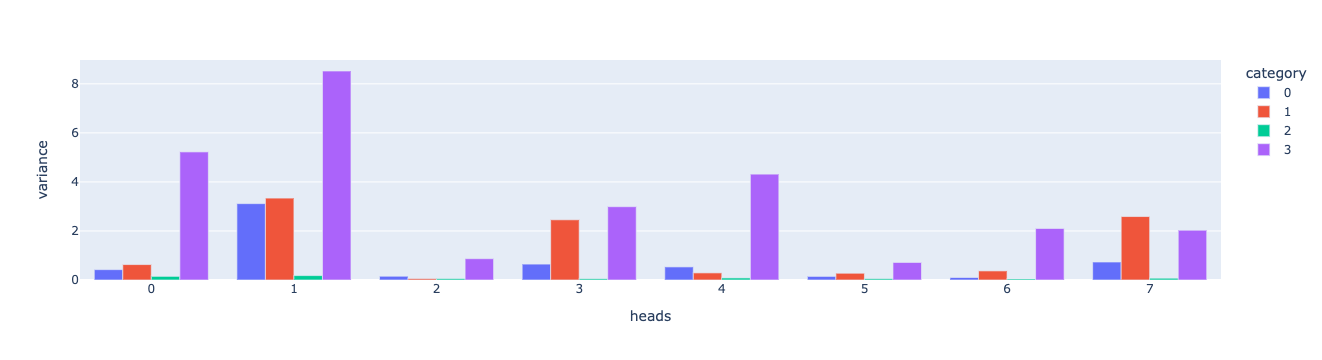

In [116]:
fig = px.bar(v.detach().numpy(), barmode="group", labels={'index': 'heads', 'value': 'variance', 'variable': 'category'})
fig.show()

Implementation of copying: "canada (k)... in -> ???"  q= k
* Q - predicted class of tokens
* K - token embeddings of previous tokens that match the class
* V - previous token

Implementation of shifting by one 
* Q - positional information of from token
* K - positional information of to token
* V - token information of from token - 1

Implementation of induction head:
* Q - current token
* K - previous copies of this token
* V - one position after previous copies of this token

In [118]:
# shift by one

sentence = 'abab'
residual_stream = [''] * 4

def v(i):
    return 2, sentence[i]

def q(i):
    return i

def k(j):
    return j + 1

i = 2 # setence[i] == a
for j in range(len(sentence)):
    if q(i) == k(j):
        location, value = v(j)
        intermediate_values[location] = value

return residual_stream[:2]

b


In [131]:
# copying

sentence = 'ca'
residual_stream = [''] * 4

def v(i):
    return 0, sentence[i]

def q(i):
    if sentence[i] == 'a':
        return (ord(sentence[i]) - ord('a')) // 2 # 0 for a and b
    return 'x'

def k(j):
    return (ord(sentence[j]) - ord('a')) // 2 # 0 for a and b

i = 1 # setence[i] == a
for j in range(i):
    if q(i) == k(j):
        location, value = v(j)
        residual_stream[location] = value

print(residual_stream[0])

In [139]:
# shift by one

sentence = 'abab'
residual_stream = [''] * 6

def v(i):
    return 2 + i, sentence[i + 1]

def q(i):
    return i

def k(j):
    return j + 1

for i in range(len(sentence)):
    for j in range(i):
        if q(i) == k(j):
            location, value = v(j)
            residual_stream[location] = value

def v(i):
    return 0, residual_stream[1 + i]

def q(i):
    return sentence[i]

def k(j):
    return residual_stream[2 + j]

i = 3 # setence[i] == a
for j in range(i):
    if q(i) == k(j):
        location, value = v(j)
        residual_stream[location] = value

print(residual_stream)

['a', '', 'b', 'a', 'b', '']


In [161]:
# find which heads have large activations for shift-by-one, 
# and small activations for not-shift-by-one
sentence = "I am a dog"
pos_pos_activations = attention_terms_for_sentence(sentences[1])[1][1] # shape: [heads, seqlen, seqlen]

torch.Size([2, 2, 8, 36, 36])


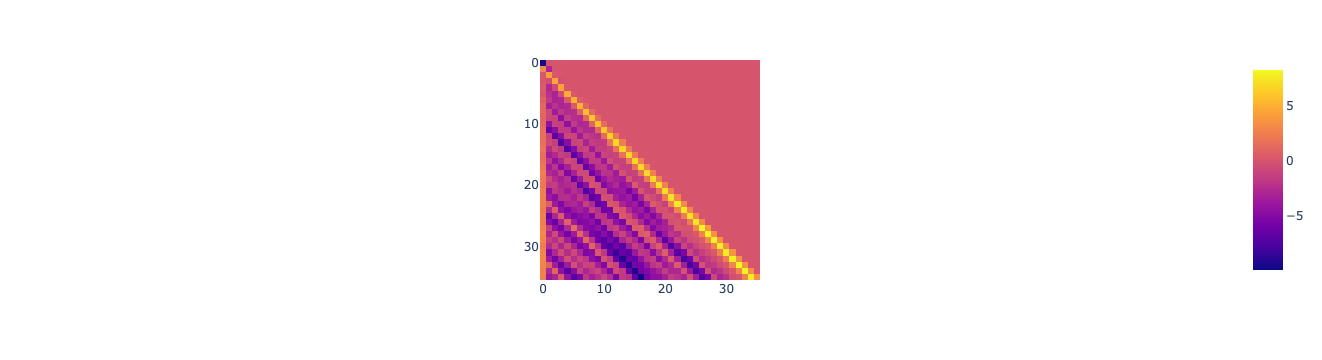

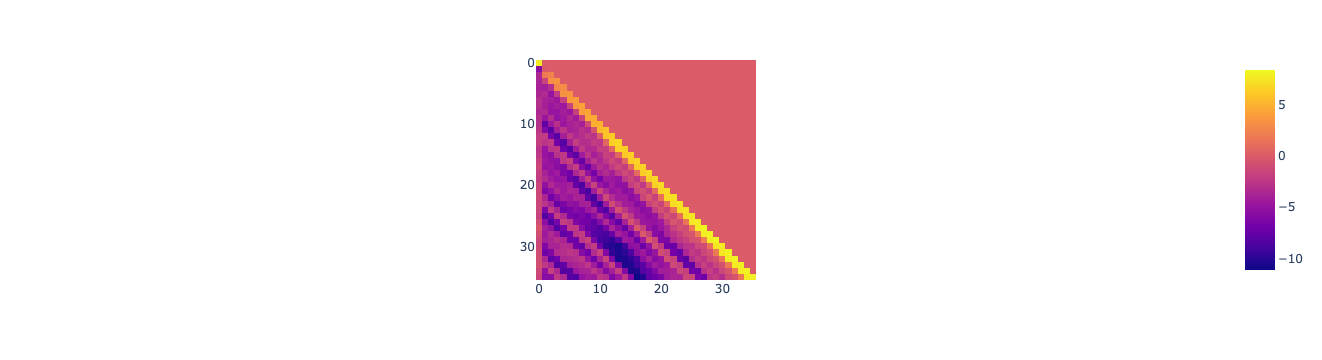

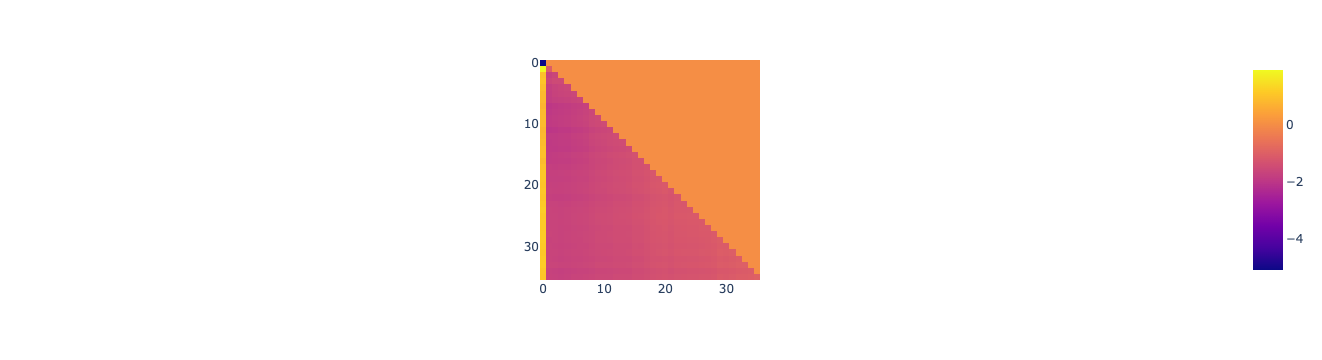

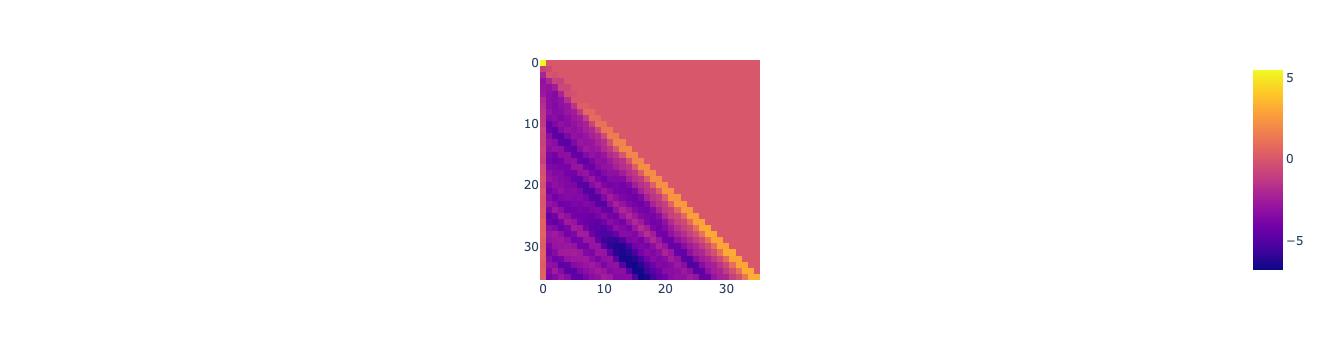

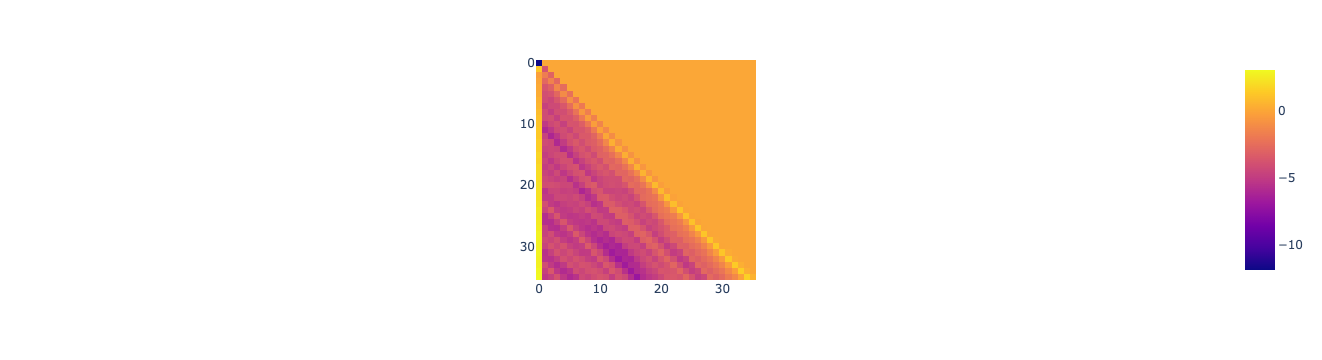

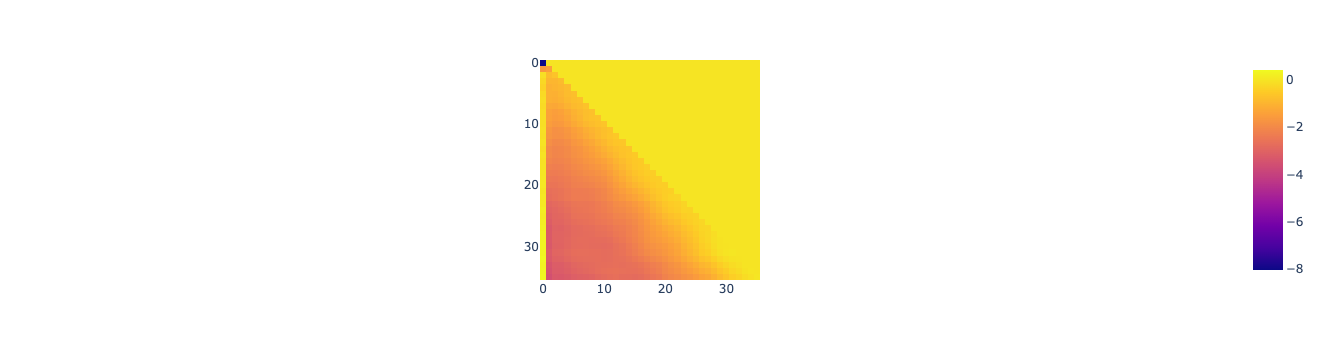

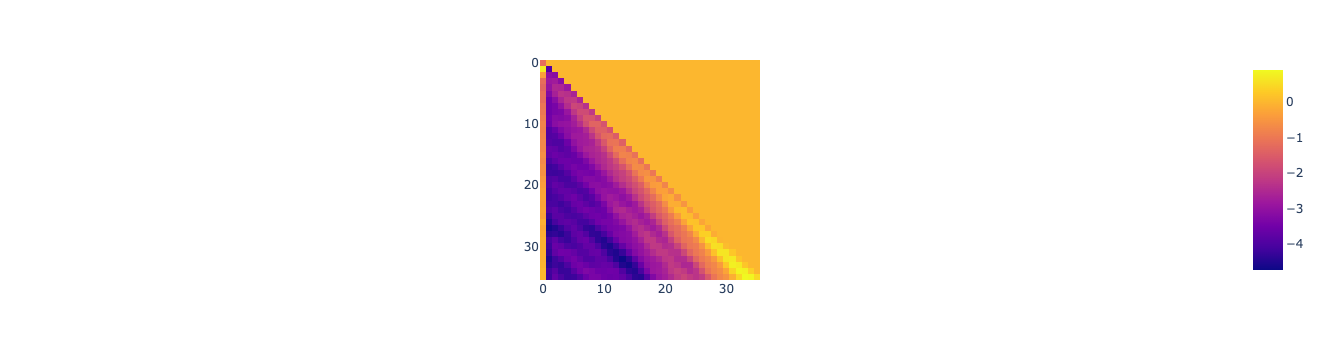

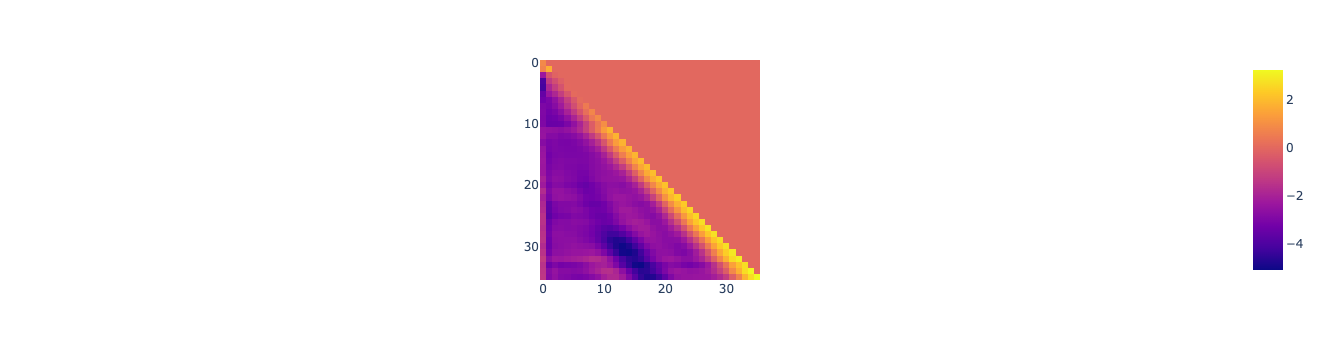

In [162]:
import pandas as pd

# shape: [heads * seqlen * seqlen, 4]
# vals: [head num, q index, k index, activation]

heads, seq_len, _ = pos_pos_activations.shape

head_num = repeat(torch.arange(heads), "heads -> heads s1 s2", s1 = seq_len, s2 = seq_len)
q_index = repeat(torch.arange(seq_len), "s1 -> heads s1 s2", heads = heads, s2 = seq_len)
k_index = repeat(torch.arange(seq_len), "s2 -> heads s1 s2", heads = heads, s1 = seq_len)

data = torch.stack((head_num, q_index, k_index, pos_pos_activations), dim=-1)
data = rearrange(data, "heads s1 s2 four -> (heads s1 s2) four")

df = pd.DataFrame(data = data,
                  columns = ['heads', 'q', 'k', 'activations'])


for head in range(pos_pos_activations.shape[0]):
    fig = px.imshow(pos_pos_activations[head].detach().numpy(), text_auto=True)# labels={'index': 'heads', 'value': 'variance', 'variable': 'category'})
    fig.show()